### Predição K50 - train_test_review - features light reduction

### Bibliotecas

In [161]:
from functools import partial
from glob import glob
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [162]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler 

In [163]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Função pronta

Abaixo temos um bloco de função que você pode apenas copiar e colar no seu codigo, e usa-lo para obter os dados de uma doença

In [164]:
# Importando bases

df_doenca_agg = pd.read_csv(r'dados_com-clima_doenca_agrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_agg['cod_muni'] = df_doenca_agg['cod_muni'].astype('int')
df_doenca_agg['ano'] = df_doenca_agg['ano'].astype('int')
df_doenca_agg['prevalencia'] = df_doenca_agg['prevalencia'].astype('float')
df_doenca_agg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_doenca_dgg = pd.read_csv(r'dados_com-clima_doenca_desagrupado.csv', sep=';', dtype='str', low_memory=False)
df_doenca_dgg['cod_muni'] = df_doenca_dgg['cod_muni'].astype('int')
df_doenca_dgg['ano'] = df_doenca_dgg['ano'].astype('int')
df_doenca_dgg['prevalencia'] = df_doenca_dgg['prevalencia'].astype('float')
df_doenca_dgg.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

df_doenca_agg_mes = pd.read_csv(r'dados_com-clima_doenca_agrupado_agg_mes.csv', sep=';', dtype='str', low_memory=False)
df_doenca_agg_mes['cod_muni'] = df_doenca_agg_mes['cod_muni'].astype('int')
df_doenca_agg_mes['ano'] = df_doenca_agg_mes['ano'].astype('int')
df_doenca_agg_mes['mes'] = df_doenca_agg_mes['mes'].astype('int')
df_doenca_agg_mes['prevalencia'] = df_doenca_agg_mes['prevalencia'].astype('float')
df_doenca_agg_mes.set_index(['cod_muni', 'doenca', 'ano', 'mes'], inplace=True)

df_doenca_dgg_mes = pd.read_csv(r'dados_com-clima_doenca_desagrupado_agg_mes.csv', sep=';', dtype='str', low_memory=False)
df_doenca_dgg_mes['cod_muni'] = df_doenca_dgg_mes['cod_muni'].astype('int')
df_doenca_dgg_mes['ano'] = df_doenca_dgg_mes['ano'].astype('int')
df_doenca_dgg_mes['mes'] = df_doenca_dgg_mes['mes'].astype('int')
df_doenca_dgg_mes['prevalencia'] = df_doenca_dgg_mes['prevalencia'].astype('float')
df_doenca_dgg_mes.set_index(['cod_muni', 'doenca', 'ano', 'mes'], inplace=True)

df_clima = pd.read_csv(r'dados_com-clima_clima.csv', sep=';', 
                       index_col=['cod_muni', 'ano', 'estacao'], low_memory=False)

df_clima_mes = pd.read_csv(r'dados_com-clima_clima_agg_mes.csv', sep=';', 
                       index_col=['cod_muni', 'ano', 'mes'], low_memory=False)

df_censo_cs = pd.read_csv(r'dados_com-clima_censo_com_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

df_censo_ss = pd.read_csv(r'dados_com-clima_censo_sem_selecao.csv', sep=';', 
                       index_col=['cod_muni'], low_memory=False)

def pega_dados(agrupado=True, selecao=True, doenca=None, ano=None, estacao=None, por_mes=False, mes=None):
    '''
    Parametros
    - agrupado: se deve ou não pegar doencas com CID agrupado
    - selecao: se deve ou não pegar dados do Censo com selecao de colunas
    - doenca: se especificado pega somente entradas daquela doença
    - ano: se especificado pega somente as entradas daquele ano
    - estacao: se especificado pega somente entradas daquela estacao
    - por_mes: se deve ou não agrupar os dados por mes, ao inves de clima
    - mes: se especificado pega somente as entradas daquele mes

    Os argumentos 'doenca', 'ano', 'estacao' e 'mes' podem tanto receber um só valor assim 
    como um lista de valores para serem selecionados.

    Retorna 2 dataframes, x e y, com dados de entrada e saida
    '''

    if estacao and por_mes:
        print('ERRO: não é possivel especificar uma estação agrupando por mes')
        return
    if estacao and mes: 
        print('ERRO: não é possivel especificar uma estação e um mes')
        return

    # tratando os parametros
    if por_mes:
        if agrupado:
            df_total = df_doenca_agg_mes.copy()
        else:
            df_total = df_doenca_dgg_mes.copy()
    else:
        if agrupado:
            df_total = df_doenca_agg.copy()
        else:
            df_total = df_doenca_dgg.copy()

    # não precisamos de index pra fazer os merges
    df_total.reset_index(inplace=True)

    if doenca: 
        if type(doenca) is not list: doenca = [doenca]
        df_total = df_total[df_total['doenca'].isin(doenca)]
    if ano: 
        if type(ano) is not list: ano = [ano]
        df_total = df_total[df_total['ano'].isin(ano)]
    if estacao: 
        if type(estacao) is not list: estacao = [estacao]
        df_total = df_total[df_total['estacao'].isin(estacao)]
    if mes:
        if type(mes) is not list: mes = [mes]
        df_total = df_total[df_total['mes'].isin(mes)]

    if por_mes:
        df_total = pd.merge(df_total, df_clima_mes, on=['cod_muni', 'ano', 'mes'])    
    else:
        df_total = pd.merge(df_total, df_clima, on=['cod_muni', 'ano', 'estacao']) 

    if selecao:
        df_total = pd.merge(df_total, df_censo_cs, on=['cod_muni'])
    else:
        df_total = pd.merge(df_total, df_censo_ss, on=['cod_muni'])

    if por_mes:
        df_total.set_index(['cod_muni', 'doenca', 'ano', 'mes'], inplace=True)
    else:
        df_total.set_index(['cod_muni', 'doenca', 'ano', 'estacao'], inplace=True)

    df_total.dropna(inplace=True)
    # separando dataframe
    y = df_total[['prevalencia']]
    x = df_total.drop(columns=['prevalencia'])
    
    del df_total
    return x, y

## K50 - Doença de Crohn

In [165]:
xi, yi= pega_dados(agrupado=True, doenca='K50', ano=[2011,2010,2013,2014]) # Dados_treino
xo, yo= pega_dados(agrupado=True, doenca='K50', ano=[2012]) # Dados_teste
# x2010 = 363 casos
# x2011 = 380 casos
# x2012 = 362 casos
# x2013 = 419 casos
# x2014 = 415 casos
# conjunto treino = 380+363+419+415 = 1577
# conjunto teste = 362- 2012 (menor quantidade)

### Identificacao_municipio

In [166]:
yo.head(1)

prevalencia
cod_muni doenca ano  estacao             
290160   K50    2012 I           0.000059

In [167]:
mu_yo = yo

In [168]:
munic = mu_yo.reset_index()[['cod_muni']]

In [169]:
munic.head(1)

cod_muni
0    290160

In [170]:
xi.head(2)

temp_media  temp_maxima  temp_minima  \
cod_muni doenca ano  estacao                                         
290100   K50    2013 O            23.546         35.5         17.9   
290160   K50    2010 P            24.936         35.7         16.3   

                              umidade_relativa  umidade_relativa_maxima  \
cod_muni doenca ano  estacao                                              
290100   K50    2013 O                  78.899                     95.0   
290160   K50    2010 P                  71.762                     96.0   

                              umidade_relativa_minima  precipitacao_media  \
cod_muni doenca ano  estacao                                                
290100   K50    2013 O                           30.0               0.072   
290160   K50    2010 P                           14.0               0.067   

                              precipitacao_max  precipitacao_min  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                    11.4               0.0   
290160   K50    2010 P                    55.0               0.0   

                              pressao_atm_med  ...  V032_domicilio02  \
cod_muni doenca ano  estacao                   ...                     
290100   K50    2013 O                970.816  ...          0.287444   
290160   K50    2010 P                970.305  ...          0.157685   

                              V033_domicilio02  V034_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.199557          0.011266   
290160   K50    2010 P                0.178948          0.009665   

                              V035_domicilio02  V036_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.057844          0.000699   
290160   K50    2010 P                0.100633          0.000469   

                              V037_domicilio02  V038_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.014061          0.964630   
290160   K50    2010 P                0.023606          0.906455   

                              V041_domicilio02  V045_domicilio02  \
cod_muni doenca ano  estacao                                       
290100   K50    2013 O                0.031819          0.484615   
290160   K50    2010 P                0.086340          0.502636   

                              V089_domicilio02  
cod_muni doenca ano  estacao                    
290100   K50    2013 O                0.515385  
290160   K50    2010 P                0.497364  

[2 rows x 96 columns]

In [171]:
yg = yo

In [172]:
xg = xo

### Criação da coluna variação de temperatura

In [173]:
xi['Temp_var']= xi['temp_maxima']-xi['temp_minima']
xo['Temp_var']= xo['temp_maxima']-xo['temp_minima']

### Preparação Dados - Extração de atributos 

In [174]:
xi = xi.drop(columns = ['temp_maxima','temp_minima','umidade_relativa_maxima','umidade_relativa_minima','precipitacao_media',
'precipitacao_max','precipitacao_min','pressao_atm_med','pressao_atm_max','pressao_atm_min',
'radiacao_max','radiacao_min','velocidade_vento_media','velocidade_vento_max','velocidade_vento_min'])

In [175]:
xo = xo.drop(columns = ['temp_maxima','temp_minima','umidade_relativa_maxima','umidade_relativa_minima','precipitacao_media',
'precipitacao_max','precipitacao_min','pressao_atm_med','pressao_atm_max','pressao_atm_min',
'radiacao_max','radiacao_min','velocidade_vento_media','velocidade_vento_max','velocidade_vento_min'])

### Análise_inicial_Features_Importance

In [176]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(xi, yi)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

([<matplotlib.axis.XTick at 0x19f8fcc4c08>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

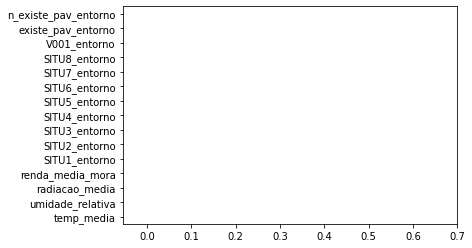

In [177]:
(pd.Series(model.feature_importances_, index=xi.columns)
   .nlargest(15).sort_values().plot.barh())
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 

### padronização dos dados 

In [178]:
sc = StandardScaler() 
sc.fit(xi)
xi = sc.transform(xi) 
xo = sc.transform(xo)
sc.fit(yi)
yi= sc.transform(yi)
yo= sc.transform(yo)

In [179]:
xi.shape

(1577, 82)

In [180]:
xo.shape

(362, 82)

In [181]:
a=np.mean(yi) #teste média y_train
a
a = [a]*len(yo)

### Predição_Algoritmos de Árvores

In [182]:
# Random_Forest_baseline
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [183]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10],
              "max_features":['auto'],
              'max_depth':[1,3,5,10,20,30],
              'max_leaf_nodes':[2,3,4,5,6,7,8],
              'min_samples_leaf':[2,3,5,7,8,9,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(xi, yi) #dados treino

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 230 tasks      | elapsed:   22.5s
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   33.9s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [184]:
random_rf.best_params_ # melhores parâmetros para serem usados

{'n_estimators': 10,
 'min_samples_split': 15,
 'min_samples_leaf': 7,
 'max_leaf_nodes': 8,
 'max_features': 'auto',
 'max_depth': 20}

In [185]:
# uso dos parãmetros indicados
m_rf=RandomForestRegressor(n_estimators= 9,
 min_samples_split = 6,
 min_samples_leaf = 5,
 max_leaf_nodes = 7,
 max_features ='auto',
 max_depth = 3)

In [186]:
yrf = m_rf.fit(xi,yi)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=7,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=9, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [187]:
y_rf= yrf.predict(xo)

In [188]:
mse_rf = round(mean_squared_error(yo, y_rf),4)
print(mse_rf)

0.103


In [189]:
b = mean_squared_error(y_rf, a)
rrf = mse_rf/b
rrf = round(rrf,4)
rrf
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.4497

### Algoritmos_Boosting

### Otimização_parâmetros

In [190]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7,9],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [191]:
# Gradient Boosting
params0= {
    'min_samples_split': [200, 300,400,500],
    'min_samples_leaf': [10, 20, 30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [4,5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5]
}

In [192]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5]
}

### Regressores_definicao

In [193]:
# GradientBoosting
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(xi, yi)
# Light Gradient Boosting
import lightgbm as lgb
lgb = lgb.LGBMRegressor(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb.fit(xi, yi)
# XGBoost
import xgboost as xgb
xgb= xgb.XGBRegressor(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb.fit(xi,yi)
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada.fit(xi, yi)

print('**Definicao_Classificadores**')

**Definicao_Classificadores**


In [194]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [195]:
random_search_gbr.fit(xi, yi)
random_search_lgb.fit(xi, yi)
random_search_xgb.fit(xi, yi)
random_search_ada.fit(xi, yi)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    2.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:   16.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   17.3s finished


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    8.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[19:57:39] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { learning rate, max depth, min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    2.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=1,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

### Gradient Boosting_Regressao

In [196]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.05, loss='ls', max_depth=4,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=300,
                          min_weight_fraction_leaf=0, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.8, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [197]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.07, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=200,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [198]:
m_gbr.fit(xi,yi)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.07, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=20, min_samples_split=200,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [199]:
y_gbr = m_gbr.predict(xo)

In [200]:
mse_gbr = round(mean_squared_error(yo, y_gbr),4)
print(mse_gbr)

0.0997


In [201]:
b = mean_squared_error(a,y_gbr)
rgb= round(mse_gbr/b,4)
rgb
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.3433

### Light_Gradiente_B_Regressao

In [202]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.2, importance_type='split',
              learning rate=0.5, learning_rate=0.001, max depth=4, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_child_weigth=9,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


In [203]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(booster='dart',boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0, importance_type='split',
              learning_rate=0.1, max_depth=11,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective='regression', random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [204]:
m_lgb.fit(xi,yi)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0, importance_type='split',
              learning_rate=0.1, max_depth=11, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective='regression',
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [205]:
y_lgb = m_lgb.predict(xo)

In [206]:
mse_lgb = round(mean_squared_error(yo, y_lgb),4)
print(mse_lgb)

0.0814


In [207]:
b = mean_squared_error(a,y_lgb)
rlg = round(mse_lgb/b,4)
rlg
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.2523

### Adaptative Boosting

In [208]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.04, loss='linear', n_estimators=50,
                  random_

In [209]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=40,
                  random_state=None)

In [210]:
m_ada.fit(xi,yi)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=40,
                  random_

In [211]:
y_ada = m_ada.predict(xo)

In [212]:
mse_ada = round(mean_squared_error(yo, y_ada),4)
print (mse_ada)

0.2736


In [213]:
b = mean_squared_error(a,y_ada)
rad = round(mse_lgb/b,4)
rad
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.3464

### Predição com o XGBoost

In [214]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='dart', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.2, learning_rate=0.001, max depth=4,
             max_delta_step=0, max_depth=1, min_child_weight=1,
             min_child_weigth=9, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [215]:
m_xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2,
             max_delta_step=0, max_depth=8, min_child_weight=1,
             min_child_weigth=1, missing=0, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [216]:
# preparação do regressor -- primeiros valores estimativos
m_xgb.fit(xi, yi)

[19:57:44] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weigth } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.2, max_delta_step=0, max_depth=8,
             min_child_weight=1, min_child_weigth=1, missing=0,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [217]:
y_xgb = m_xgb.predict(xo)

In [218]:
mse_xgb = round(mean_squared_error(yo, y_xgb),4)
print (mse_xgb)

0.0552


In [219]:
b = mean_squared_error(a,y_xgb)
rxg= round(mse_xgb/b,4)
rxg
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

0.207

In [220]:
models=['Random_Forest','GradientBoost','LightGBM','AdaBoost',"XGBoost"]
r=[rrf,rgb,rlg,rad,rxg]
pd.DataFrame(list(zip(r)), columns =['Comparacao_teste_ytrain_medio_K500_agrup_82atributos'], index=models)

Comparacao_teste_ytrain_medio_K500_agrup_82atributos
Random_Forest                                             0.4497   
GradientBoost                                             0.3433   
LightGBM                                                  0.2523   
AdaBoost                                                  0.3464   
XGBoost                                                   0.2070

### Cat_Boost

In [221]:
! pip install catboost

In [222]:
# catboost Regressão
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from catboost import CatBoostRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

xi, yi = make_regression(n_samples=1000, n_features=10, n_informative=5, random_state=1)
m_cat = CatBoostRegressor(verbose=0, n_estimators=100)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(m_cat, xi, yi, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))
m_cat = CatBoostRegressor(verbose=0, n_estimators=100)
m_cat.fit(xi, yi)
y_cat = model.predict(xo)


MAE: -9.623 (0.930)


### Avaliação do Cat_Boost_Erros

In [223]:
mse_cat = round(mean_squared_error(yo, y_cat),4)
b = mean_squared_error(a,y_cat)
rcat= round(mse_cat/b,4)

print (mse_xgb)
print (rcat)


0.0552
125727253.4093


### Otimização de Parâmetros

In [224]:
# Cat_Boost
params_ct= {
    'learning_rate': [0.001, 0.01, 0.04, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.8, 1, 1.5],
    'depth': [3,4,5,8,10,11,12]
}

In [225]:
random_search_cat = RandomizedSearchCV(estimator=m_cat,param_distributions=params_ct,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [226]:
random_search_cat.fit(xi, yi)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:  1.3min remaining:   25.2s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.5min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=<catboost.core.CatBoostRegressor object at 0x0000019FE3E37A48>,
                   iid='warn', n_iter=5, n_jobs=-1,
                   param_distributions={'depth': [3, 4, 5, 8, 10, 11, 12],
                                        'learning_rate': [0.001, 0.01, 0.04,
                                                          0.05, 0.07, 0.1, 0.2,
                                                          0.3, 0.4, 0.5, 0.8, 1,
                                                          1.5]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=3)

In [227]:
print(random_search_cat.best_estimator_)

In [228]:
print(random_search_cat.best_score_)

0.9807922603741224


In [229]:
print(random_search_cat.best_params_)

{'learning_rate': 1, 'depth': 3}


In [230]:
m_cat = CatBoostRegressor(learning_rate=0.2, depth=5)

In [231]:
m_cat.fit(xi,yi)

0:	learn: 112.4944242	total: 2.56ms	remaining: 2.56s
1:	learn: 100.1951940	total: 4.33ms	remaining: 2.16s
2:	learn: 87.5966332	total: 6.42ms	remaining: 2.13s
3:	learn: 76.6107749	total: 8.2ms	remaining: 2.04s
4:	learn: 68.0150723	total: 9.87ms	remaining: 1.96s
5:	learn: 60.8158171	total: 11.4ms	remaining: 1.88s
6:	learn: 54.3893067	total: 13.3ms	remaining: 1.89s
7:	learn: 49.2253514	total: 15ms	remaining: 1.86s
8:	learn: 44.9462479	total: 16.7ms	remaining: 1.84s
9:	learn: 40.8459370	total: 18.4ms	remaining: 1.82s
10:	learn: 37.1900156	total: 20.3ms	remaining: 1.83s
11:	learn: 34.3659988	total: 22ms	remaining: 1.81s
12:	learn: 31.8393131	total: 23.6ms	remaining: 1.79s
13:	learn: 29.6428679	total: 25.2ms	remaining: 1.77s
14:	learn: 27.0980336	total: 26.8ms	remaining: 1.76s
15:	learn: 25.4486137	total: 28.6ms	remaining: 1.76s
16:	learn: 23.9547185	total: 30.3ms	remaining: 1.75s
17:	learn: 22.4962012	total: 31.8ms	remaining: 1.73s
18:	learn: 21.4077006	total: 33.7ms	remaining: 1.74s
19:	le

184:	learn: 3.9771710	total: 311ms	remaining: 1.37s
185:	learn: 3.9525636	total: 313ms	remaining: 1.37s
186:	learn: 3.9316464	total: 314ms	remaining: 1.37s
187:	learn: 3.9128894	total: 316ms	remaining: 1.36s
188:	learn: 3.9014739	total: 318ms	remaining: 1.36s
189:	learn: 3.8840349	total: 319ms	remaining: 1.36s
190:	learn: 3.8613633	total: 321ms	remaining: 1.36s
191:	learn: 3.8575840	total: 323ms	remaining: 1.36s
192:	learn: 3.8456731	total: 325ms	remaining: 1.36s
193:	learn: 3.8199657	total: 327ms	remaining: 1.36s
194:	learn: 3.7975445	total: 329ms	remaining: 1.36s
195:	learn: 3.7719517	total: 330ms	remaining: 1.35s
196:	learn: 3.7541897	total: 332ms	remaining: 1.35s
197:	learn: 3.7312153	total: 334ms	remaining: 1.35s
198:	learn: 3.7195446	total: 335ms	remaining: 1.35s
199:	learn: 3.7079064	total: 337ms	remaining: 1.35s
200:	learn: 3.6865080	total: 338ms	remaining: 1.34s
201:	learn: 3.6616098	total: 340ms	remaining: 1.34s
202:	learn: 3.6444887	total: 342ms	remaining: 1.34s
203:	learn: 

368:	learn: 1.7332042	total: 616ms	remaining: 1.05s
369:	learn: 1.7238580	total: 618ms	remaining: 1.05s
370:	learn: 1.7170126	total: 620ms	remaining: 1.05s
371:	learn: 1.7119490	total: 621ms	remaining: 1.05s
372:	learn: 1.7080203	total: 623ms	remaining: 1.05s
373:	learn: 1.7065913	total: 625ms	remaining: 1.04s
374:	learn: 1.6997782	total: 626ms	remaining: 1.04s
375:	learn: 1.6931809	total: 628ms	remaining: 1.04s
376:	learn: 1.6850493	total: 630ms	remaining: 1.04s
377:	learn: 1.6775462	total: 631ms	remaining: 1.04s
378:	learn: 1.6702833	total: 633ms	remaining: 1.04s
379:	learn: 1.6609785	total: 635ms	remaining: 1.03s
380:	learn: 1.6540113	total: 636ms	remaining: 1.03s
381:	learn: 1.6498409	total: 638ms	remaining: 1.03s
382:	learn: 1.6448746	total: 640ms	remaining: 1.03s
383:	learn: 1.6387346	total: 642ms	remaining: 1.03s
384:	learn: 1.6301941	total: 643ms	remaining: 1.03s
385:	learn: 1.6220295	total: 645ms	remaining: 1.02s
386:	learn: 1.6129154	total: 646ms	remaining: 1.02s
387:	learn: 

528:	learn: 0.9732992	total: 924ms	remaining: 823ms
529:	learn: 0.9658874	total: 927ms	remaining: 822ms
530:	learn: 0.9619360	total: 929ms	remaining: 821ms
531:	learn: 0.9592772	total: 932ms	remaining: 820ms
532:	learn: 0.9572541	total: 934ms	remaining: 818ms
533:	learn: 0.9514315	total: 936ms	remaining: 817ms
534:	learn: 0.9477678	total: 938ms	remaining: 816ms
535:	learn: 0.9451529	total: 941ms	remaining: 814ms
536:	learn: 0.9438635	total: 944ms	remaining: 814ms
537:	learn: 0.9399120	total: 947ms	remaining: 814ms
538:	learn: 0.9377604	total: 950ms	remaining: 812ms
539:	learn: 0.9328956	total: 952ms	remaining: 811ms
540:	learn: 0.9283344	total: 954ms	remaining: 809ms
541:	learn: 0.9242684	total: 956ms	remaining: 808ms
542:	learn: 0.9221530	total: 958ms	remaining: 806ms
543:	learn: 0.9200178	total: 960ms	remaining: 805ms
544:	learn: 0.9160215	total: 962ms	remaining: 803ms
545:	learn: 0.9125559	total: 966ms	remaining: 803ms
546:	learn: 0.9119546	total: 968ms	remaining: 801ms
547:	learn: 

698:	learn: 0.5395368	total: 1.3s	remaining: 559ms
699:	learn: 0.5382963	total: 1.3s	remaining: 557ms
700:	learn: 0.5378263	total: 1.3s	remaining: 555ms
701:	learn: 0.5364758	total: 1.3s	remaining: 554ms
702:	learn: 0.5356738	total: 1.31s	remaining: 552ms
703:	learn: 0.5335783	total: 1.31s	remaining: 550ms
704:	learn: 0.5330507	total: 1.31s	remaining: 549ms
705:	learn: 0.5305925	total: 1.31s	remaining: 547ms
706:	learn: 0.5278420	total: 1.31s	remaining: 545ms
707:	learn: 0.5261319	total: 1.32s	remaining: 543ms
708:	learn: 0.5240581	total: 1.32s	remaining: 541ms
709:	learn: 0.5216264	total: 1.32s	remaining: 540ms
710:	learn: 0.5193590	total: 1.32s	remaining: 538ms
711:	learn: 0.5166929	total: 1.32s	remaining: 536ms
712:	learn: 0.5147120	total: 1.33s	remaining: 534ms
713:	learn: 0.5132780	total: 1.33s	remaining: 532ms
714:	learn: 0.5110719	total: 1.33s	remaining: 530ms
715:	learn: 0.5095237	total: 1.33s	remaining: 528ms
716:	learn: 0.5087016	total: 1.33s	remaining: 526ms
717:	learn: 0.50

878:	learn: 0.2947835	total: 1.6s	remaining: 221ms
879:	learn: 0.2938213	total: 1.6s	remaining: 219ms
880:	learn: 0.2926335	total: 1.61s	remaining: 217ms
881:	learn: 0.2919792	total: 1.61s	remaining: 215ms
882:	learn: 0.2909339	total: 1.61s	remaining: 213ms
883:	learn: 0.2902772	total: 1.61s	remaining: 212ms
884:	learn: 0.2895469	total: 1.61s	remaining: 210ms
885:	learn: 0.2884741	total: 1.61s	remaining: 208ms
886:	learn: 0.2883898	total: 1.62s	remaining: 206ms
887:	learn: 0.2879945	total: 1.62s	remaining: 204ms
888:	learn: 0.2872009	total: 1.62s	remaining: 202ms
889:	learn: 0.2860168	total: 1.62s	remaining: 200ms
890:	learn: 0.2859690	total: 1.62s	remaining: 199ms
891:	learn: 0.2849050	total: 1.63s	remaining: 197ms
892:	learn: 0.2843144	total: 1.63s	remaining: 195ms
893:	learn: 0.2836559	total: 1.63s	remaining: 193ms
894:	learn: 0.2827657	total: 1.63s	remaining: 192ms
895:	learn: 0.2823586	total: 1.64s	remaining: 190ms
896:	learn: 0.2817930	total: 1.64s	remaining: 188ms
897:	learn: 0.

In [232]:
y_cat = m_cat.predict(xo)

In [233]:
mse_cat = round(mean_squared_error(yo, y_cat),4)
print(mse_cat)

10335.0935


In [234]:
b = mean_squared_error(a,y_cat)
rcat= round(mse_cat/b,4)
rcat
# se r maior que 1.0, modelo pior que modelo simples (media y_train)

1.0058

### Graficos

In [235]:
y_xgb=pd.DataFrame(y_xgb)
y_lgb=pd.DataFrame(y_lgb)
y_lgb.columns = ['lgb']
y_xgb.columns = ["xgb"]
y_xgb.head(2)

xgb
0  0.453641
1  0.182360

In [236]:
yo= pd.DataFrame(yo)
yo.columns = ['prevalencia']
yo.head(1)

prevalencia
0     0.113943

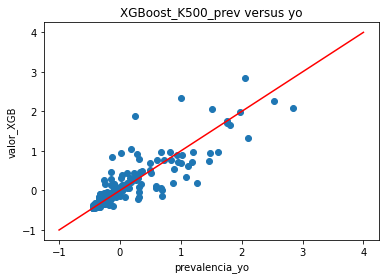

In [237]:
fig = plt.scatter(yo['prevalencia'], y_xgb['xgb'])
plt.title("XGBoost_K500_prev versus yo")
plt.xlabel("prevalencia_yo")
plt.ylabel("valor_XGB")
x=[-1,0,1,2,3,4]
y=[-1,0,1,2,3,4]
plt.plot(x, y, color='r')
plt.show() 

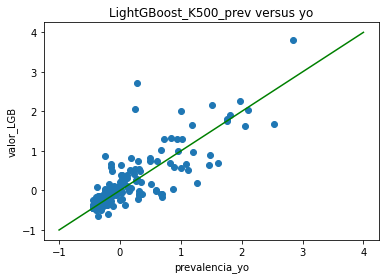

In [238]:
fig = plt.scatter(yo['prevalencia'], y_lgb['lgb'])
plt.title("LightGBoost_K500_prev versus yo")
plt.xlabel("prevalencia_yo")
plt.ylabel("valor_LGB")
x=[-1,0,1,2,3,4]
y=[-1,0,1,2,3,4]
plt.plot(x, y, color='g')
plt.show() 

In [239]:
mod = columns=[y_lgb['lgb'],y_xgb['xgb']]

In [240]:
y_ada=pd.DataFrame(y_ada)
y_ada.columns = ['ada']
y_ada.head(2)

ada
0  0.357137
1  0.357137

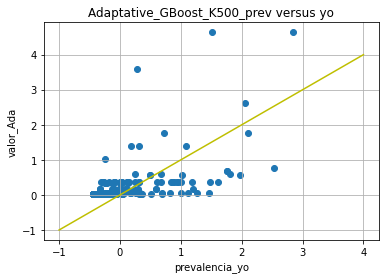

In [241]:
fig = plt.scatter(yo['prevalencia'], y_ada['ada'])
plt.title("Adaptative_GBoost_K500_prev versus yo")
plt.xlabel("prevalencia_yo")
plt.ylabel("valor_Ada")
x=[-1,0,1,2,3,4]
y=[-1,0,1,2,3,4]
plt.plot(x, y, color='y')
plt.grid()
plt.show() 

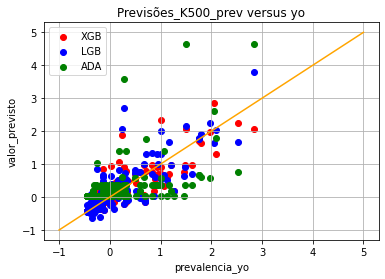

In [242]:
plt.scatter(yo['prevalencia'],y_xgb['xgb'],color='red',label="XGB")
plt.scatter(yo['prevalencia'],y_lgb['lgb'],color='blue',label = "LGB")
plt.scatter(yo['prevalencia'],y_ada['ada'],color='green',label = "ADA")
plt.title("Previsões_K500_prev versus yo")
x=[-1,0,1,2,3,4,5]
y=[-1,0,1,2,3,4,5]
plt.plot(x, y, color='orange')
plt.xlabel("prevalencia_yo")
plt.ylabel("valor_previsto")
plt.grid()
plt.legend()
plt.show()

In [256]:
loc= (munic['cod_muni'],yo['prevalencia'],y_xgb['xgb'])
loc = pd.DataFrame (loc).transpose()
loc.head(2)

cod_muni  prevalencia       xgb
0  290160.0     0.113943  0.453641
1  290160.0     0.113943  0.182360

In [259]:
loc['dif'] = (loc['prevalencia']-loc['xgb']) * 100 /loc['prevalencia']

In [265]:
B = loc[(loc.dif < 3) & (loc.dif > -3) & (loc.cod_muni < 300000)]
B.head(2)

cod_muni  prevalencia       xgb       dif
0  290160.0     0.113943  0.453641 -2.981314
1  290160.0     0.113943  0.182360 -0.600451

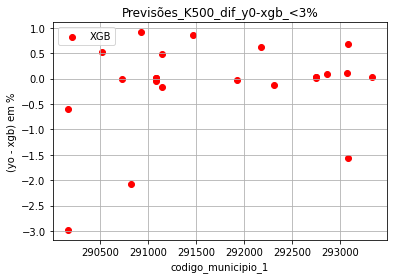

In [266]:
plt.scatter(B['cod_muni'],B['dif'],color='red',label="XGB")

plt.title("Previsões_K500_dif_y0-xgb_<3%")
plt.xlabel("codigo_municipio_1")
plt.ylabel("(yo - xgb) em %")
plt.grid()
plt.legend()
plt.show()

In [257]:
A= loc[loc.cod_muni < 300000]
A.head(2)


cod_muni  prevalencia       xgb
0  290160.0     0.113943  0.453641
1  290160.0     0.113943  0.182360

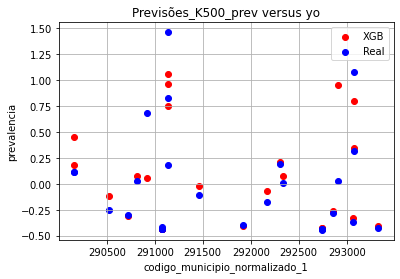

In [258]:
plt.scatter(A['cod_muni'],A['xgb'],color='red',label="XGB")
plt.scatter(A['cod_muni'],A['prevalencia'],color='blue',label = "Real")
plt.title("Previsões_K500_prev versus yo")
plt.xlabel("codigo_municipio_1")
plt.ylabel("prevalencia")
plt.grid()
plt.legend()
plt.show()

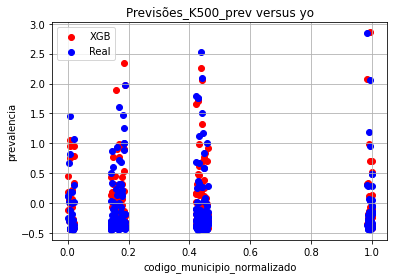

In [247]:
plt.scatter(ent['municipio'],y_xgb['xgb'],color='red',label="XGB")
plt.scatter(ent['municipio'],yo['prevalencia'],color='blue',label = "Real")
plt.title("Previsões_K500_prev versus yo")
plt.xlabel("codigo_municipio_normalizado")
plt.ylabel("prevalencia")
plt.grid()
plt.legend()
plt.show()

In [268]:
B = loc[(loc.dif < 0.5) & (loc.dif > -0.5) & (loc.cod_muni < 300000)]
B.head(30)
# 290720 = Juazeiro; 291080 = Feira de Santana; 291140 = Paulo Afonso; 291920 = Salvador; 202305 = Riberia do Pombal
# 292740 = Salvador; 292860 = Santo Antonio do Jesus; 293070 = Salvador; 293330 = Vitoria da Conquista; 

cod_muni  prevalencia       xgb       dif
3   290720.0    -0.304672 -0.306242 -0.005153
6   291080.0    -0.435249 -0.434016  0.002834
7   291080.0    -0.435249 -0.434016  0.002834
8   291080.0    -0.435249 -0.434016  0.002834
9   291080.0    -0.417967 -0.435625 -0.042248
10  291140.0     0.822515  0.964000 -0.172014
12  291140.0     1.460038  0.751685  0.485161
14  291920.0    -0.393004 -0.407261 -0.036278
16  292305.0     0.187872  0.212598 -0.131612
18  292740.0    -0.430448 -0.420847  0.022307
19  292740.0    -0.430448 -0.420847  0.022307
20  292740.0    -0.444850 -0.437976  0.015454
21  292860.0    -0.285470 -0.262342  0.081016
23  293070.0    -0.370921 -0.326618  0.119441
26  293330.0    -0.420847 -0.409873  0.026077

In [272]:
C = loc[(loc.cod_muni < 360000) & (loc.cod_muni > 340000) & (loc.dif < 0.5) & (loc.dif > -0.5)]
C.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148 entries, 124 to 298
Data columns (total 4 columns):
cod_muni       148 non-null float64
prevalencia    148 non-null float64
xgb            148 non-null float64
dif            148 non-null float64
dtypes: float64(4)
memory usage: 5.8 KB


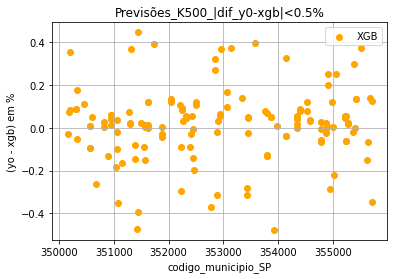

In [274]:
plt.scatter(C['cod_muni'],C['dif'],color='orange',label="XGB")

plt.title("Previsões_K500_|dif_y0-xgb|<0.5%")
plt.xlabel("codigo_municipio_SP")
plt.ylabel("(yo - xgb) em %")
plt.grid()
plt.legend()
plt.show()

In [275]:
C.head(20)

cod_muni  prevalencia       xgb       dif
124  350160.0    -0.361319 -0.371428 -0.027977
125  350190.0    -0.305632 -0.283267  0.073176
126  350200.0     1.800883  1.650740  0.083372
127  350210.0    -0.275868 -0.178005  0.354748
132  350320.0    -0.406445 -0.369918  0.089871
133  350320.0    -0.406445 -0.370974  0.087273
134  350330.0    -0.370921 -0.305662  0.175936
135  350330.0    -0.289310 -0.304124 -0.051206
136  350450.0    -0.333476 -0.295820  0.112918
137  350570.0    -0.412206 -0.407857  0.010551
138  350570.0    -0.372841 -0.407857 -0.093917
139  350570.0    -0.412206 -0.408913  0.007989
140  350570.0    -0.372841 -0.408277 -0.095044
142  350600.0    -0.424688 -0.403624  0.049599
143  350670.0     0.253161  0.319337 -0.261400
146  350830.0     1.751916  1.748291  0.002069
147  350830.0     1.751916  1.700835  0.029157
148  350900.0    -0.341157 -0.385776 -0.130788
149  350950.0    -0.425648 -0.420138  0.012946
150  350950.0    -0.434289 -0.416960  0.039901

In [279]:
D= loc[(loc.cod_muni < 430500) & (loc.cod_muni > 410000) & (loc.dif < 0.5) & (loc.dif > -0.5)]
D.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 299 to 309
Data columns (total 4 columns):
cod_muni       10 non-null float64
prevalencia    10 non-null float64
xgb            10 non-null float64
dif            10 non-null float64
dtypes: float64(4)
memory usage: 400.0 bytes


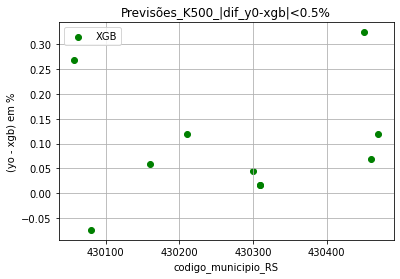

In [283]:
plt.scatter(D['cod_muni'],D['dif'],color='green',label="XGB")

plt.title("Previsões_K500_|dif_y0-xgb|<0.5%")
plt.xlabel("codigo_municipio_RS")
plt.ylabel("(yo - xgb) em %")
plt.grid()
plt.legend()
plt.show()

In [282]:
D.head(50)

cod_muni  prevalencia       xgb       dif
299  430057.0     2.843579  2.077660  0.269350
300  430080.0     0.298287  0.320457 -0.074326
301  430160.0    -0.369961 -0.347935  0.059534
302  430210.0    -0.362280 -0.319234  0.118818
303  430300.0    -0.337316 -0.322288  0.044553
304  430310.0    -0.370921 -0.365059  0.015803
305  430310.0    -0.370921 -0.365059  0.015803
307  430450.0    -0.272028 -0.183811  0.324293
308  430460.0    -0.422767 -0.393415  0.069429
309  430470.0    -0.289310 -0.254636  0.119849